In [46]:
import pandas as pd
import numpy as np
import pprint
import json
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
import tensorflow as tf
import tensorflow_docs as tfdocs
from tensorflow import keras
from tensorflow.keras import layers, activations
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
keras.__version__

'3.8.0'

In [3]:
dataset = pd.read_csv('car_price_prediction.csv')

dataset.sample(10)

,ID,Price,Levy,Manufacturer,Model,Prod. year,Category,Leather interior,Fuel type,Engine volume,Mileage,Cylinders,Gear box type,Drive wheels,Doors,Wheel,Color,Airbags
4399,45795980,21012,-,KIA,Optima X,2012,Sedan,Yes,Petrol,2.0 Turbo,155000 km,12.0,Tiptronic,Front,04-May,Left wheel,Carnelian red,12
761,45815241,3763,1053,MERCEDES-BENZ,ML 350,2014,Jeep,Yes,Petrol,3.5,94362 km,6.0,Automatic,Rear,04-May,Left wheel,White,12
17728,43889777,97219,-,LEXUS,GX 460,2015,Jeep,Yes,Petrol,4.6,57000 km,8.0,Automatic,4x4,04-May,Left wheel,White,12
3416,45762786,314,1017,MERCEDES-BENZ,GLA 250,2017,Jeep,Yes,Petrol,2,46413 km,4.0,Automatic,4x4,04-May,Left wheel,Blue,0
5808,45804539,22063,836,HYUNDAI,Tucson,2010,Jeep,Yes,Diesel,2,216751 km,4.0,Automatic,Front,04-May,Left wheel,Silver,4
5874,45801836,14834,687,HYUNDAI,Elantra,2010,Sedan,Yes,Petrol,1.6,87640 km,4.0,Automatic,Front,04-May,Left wheel,Grey,4
7820,44397830,32302,-,AUDI,Q5 Prestige,2010,Jeep,Yes,Petrol,3.2,182011 km,6.0,Tiptronic,4x4,04-May,Left wheel,Black,12
11543,45804503,22947,836,HYUNDAI,Tucson,2010,Jeep,Yes,Diesel,2,199356 km,4.0,Automatic,Front,04-May,Left wheel,White,4
5972,45507111,15950,-,TOYOTA,Prius C,2013,Hatchback,No,Hybrid,1.5,91200 km,2.0,Automatic,Front,04-May,Left wheel,Grey,6
15361,45646179,282,1598,MERCEDES-BENZ,ML 350,2008,Jeep,Yes,Diesel,3,213998 km,6.0,Automatic,4x4,04-May,Left wheel,Silver,12


In [4]:
dataset.shape

(19237, 18)

In [5]:
dataset.isna().sum()

ID                  0
Price               0
Levy                0
Manufacturer        0
Model               0
Prod. year          0
Category            0
Leather interior    0
Fuel type           0
Engine volume       0
Mileage             0
Cylinders           0
Gear box type       0
Drive wheels        0
Doors               0
Wheel               0
Color               0
Airbags             0
dtype: int64

In [6]:
dataset[['Levy', 'Engine volume', 'Cylinders']].describe()

,Cylinders
count,19237.000000
mean,4.582991
std,1.199933
min,1.000000
25%,4.000000
50%,4.000000
75%,4.000000
max,16.000000


In [7]:
dataset['Manufacturer'].value_counts()

Manufacturer
HYUNDAI          3769
TOYOTA           3662
MERCEDES-BENZ    2076
FORD             1111
CHEVROLET        1069
                 ... 
LAMBORGHINI         1
PONTIAC             1
SATURN              1
ASTON MARTIN        1
GREATWALL           1
Name: count, Length: 65, dtype: int64

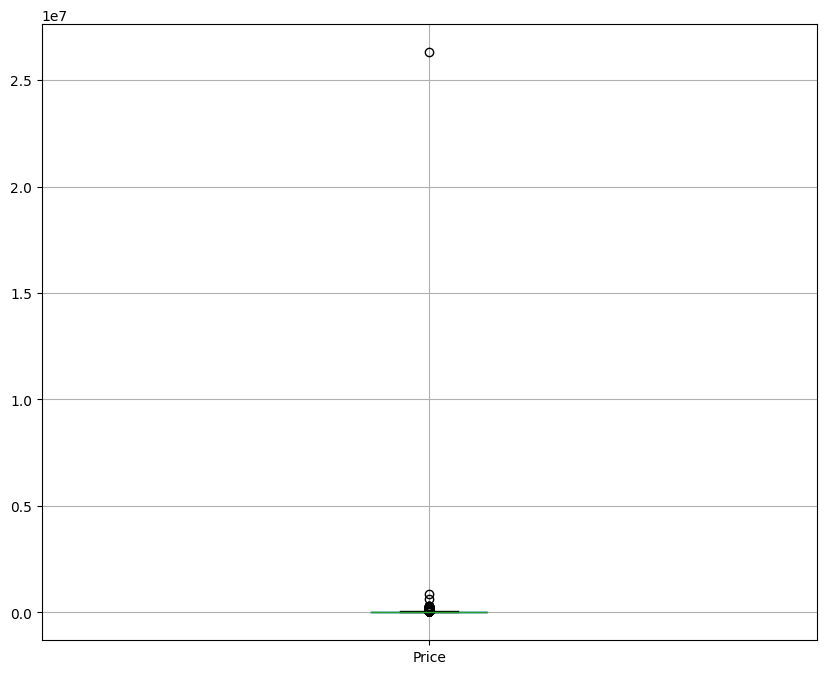

In [8]:
plt.figure(figsize=(10, 8))

dataset.boxplot('Price')

plt.show()

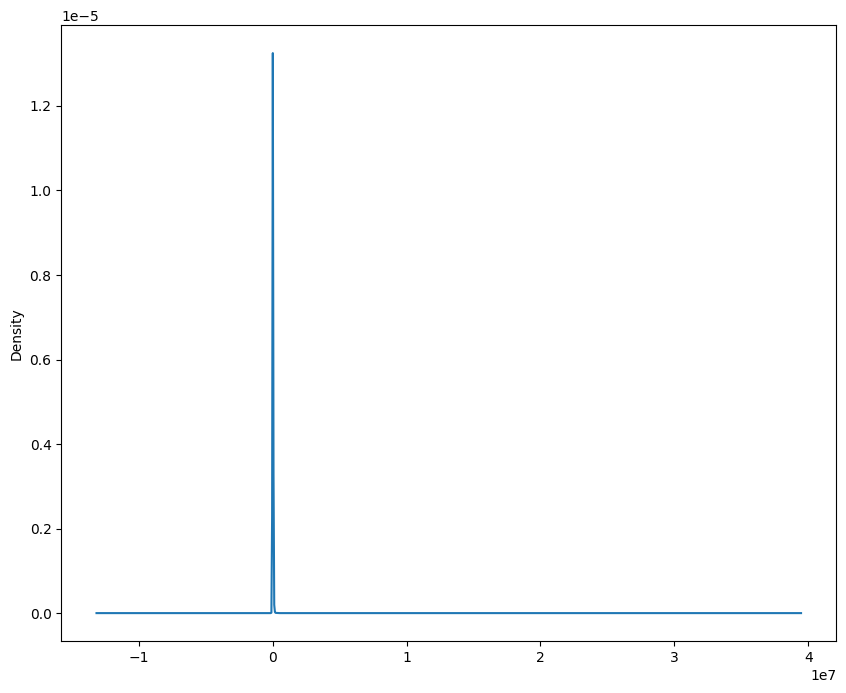

In [9]:
plt.figure(figsize=(10, 8))

dataset['Price'].plot.kde()

plt.show()

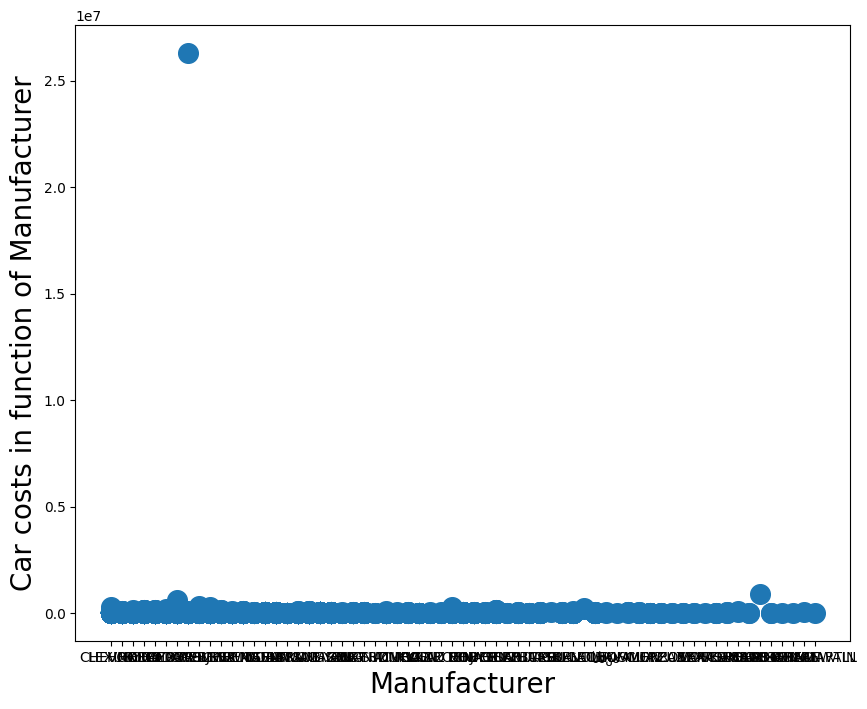

In [10]:
plt.figure(figsize=(10, 8))

plt.scatter(dataset['Manufacturer'], dataset['Price'], s=200)

plt.xlabel('Manufacturer', fontsize=20)
plt.ylabel('Car costs in function of Manufacturer', fontsize=20)
plt.show()

In [11]:
dataset['Levy'] = pd.to_numeric(dataset['Levy'], errors='coerce').fillna(0)

In [12]:
dataset['Engine volume'] = dataset['Engine volume'].str.extract(r'(\d+\.?\d*)').astype(float)

In [13]:
dataset['Mileage'] = dataset['Mileage'].str.replace(' km', '').astype(int)

In [14]:
categorical_features = [
    'Manufacturer', 'Model', 'Category', 'Leather interior',
    'Fuel type', 'Gear box type', 'Drive wheels', 'Doors', 'Wheel', 'Color'
]
dataset = pd.get_dummies(dataset, columns=categorical_features, drop_first=True)

In [15]:
numeric_features = ['Levy', 'Prod. year', 'Engine volume', 'Mileage', 'Cylinders', 'Airbags']
scaler = MinMaxScaler()
dataset[numeric_features] = scaler.fit_transform(dataset[numeric_features])

In [16]:
X = dataset.drop(columns=['ID', 'Price'])
y = dataset['Price']

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [18]:
base_model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(32, activation='relu'),
    Dense(1)  # Single output for regression
])
base_model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])


C:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [19]:
base_history = base_model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=32,
    verbose=1
)

Epoch 1/50
385/385 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - loss: 171055775744.0000 - mae: 24031.3242 - val_loss: 507119456.0000 - val_mae: 14700.4287
Epoch 2/50
385/385 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 197606604800.0000 - mae: 21972.8496 - val_loss: 357471488.0000 - val_mae: 11536.9668
Epoch 3/50
385/385 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 51751329792.0000 - mae: 13448.5156 - val_loss: 301027552.0000 - val_mae: 11187.5254
Epoch 4/50
385/385 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 1281487488.0000 - mae: 11665.2373 - val_loss: 289127040.0000 - val_mae: 11254.2354
Epoch 5/50
385/385 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 74120454144.0000 - mae: 14108.5439 - val_loss: 280035136.0000 - val_mae: 11128.3887
Epoch 6/50
385/385 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 31085862912.0000 - mae: 12724.3877 - val_loss: 272441152.0000 - val_mae: 10939.6387
Epoch 7/50
385/385 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 124013256704.0000 - mae: 15997.1445 - val_loss: 265890048.0000 - val_mae: 1

In [20]:
base_loss, base_mae = base_model.evaluate(X_test, y_test, verbose=0)
print(f"Base Model - Mean Absolute Error: {base_mae}")

Base Model - Mean Absolute Error: 9715.6025390625


In [27]:
# Strategy 2: Enhanced Model
# -------------------------
# Build an enhanced regression model with custom layers
def build_custom_model(input_shape):
    inputs = Input(shape=(input_shape,))  # Ensure input shape is in tuple format
    x = Dense(128, activation='relu')(inputs)
    x = Dropout(0.3)(x)
    x = Dense(64, activation='relu')(x)
    x = Dense(32, activation='relu')(x)
    outputs = Dense(1)(x)
    return Model(inputs, outputs)

In [28]:
# Create the custom model
input_dim = X_train.shape[1]  # Ensure X_train is properly defined
enhanced_model = build_custom_model(input_dim)

In [29]:
enhanced_model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error', metrics=['mae'])

In [30]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [31]:
enhanced_history = enhanced_model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=100,
    batch_size=32,
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/100
385/385 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - loss: 25421250560.0000 - mae: 16785.4043 - val_loss: 285806464.0000 - val_mae: 11213.1641
Epoch 2/100
385/385 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 9430792192.0000 - mae: 11434.1182 - val_loss: 261147184.0000 - val_mae: 10834.9951
Epoch 3/100
385/385 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 12058804224.0000 - mae: 11650.2988 - val_loss: 248202352.0000 - val_mae: 10464.7783
Epoch 4/100
385/385 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 63792582656.0000 - mae: 12959.8496 - val_loss: 238792064.0000 - val_mae: 10082.3486
Epoch 5/100
385/385 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 8178610688.0000 - mae: 10889.3340 - val_loss: 236715712.0000 - val_mae: 10291.4189
Epoch 6/100
385/385 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 2589005056.0000 - mae: 10418.2451 - val_loss: 236245760.0000 - val_mae: 10454.4297
Epoch 7/100
385/385 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 10298310656.0000 - mae: 10772.3379 - val_loss: 229512112.0000 - val_mae

In [32]:
enhanced_loss, enhanced_mae = enhanced_model.evaluate(X_test, y_test, verbose=0)
print(f"Enhanced Model - Mean Absolute Error: {enhanced_mae}")

Enhanced Model - Mean Absolute Error: 9558.044921875


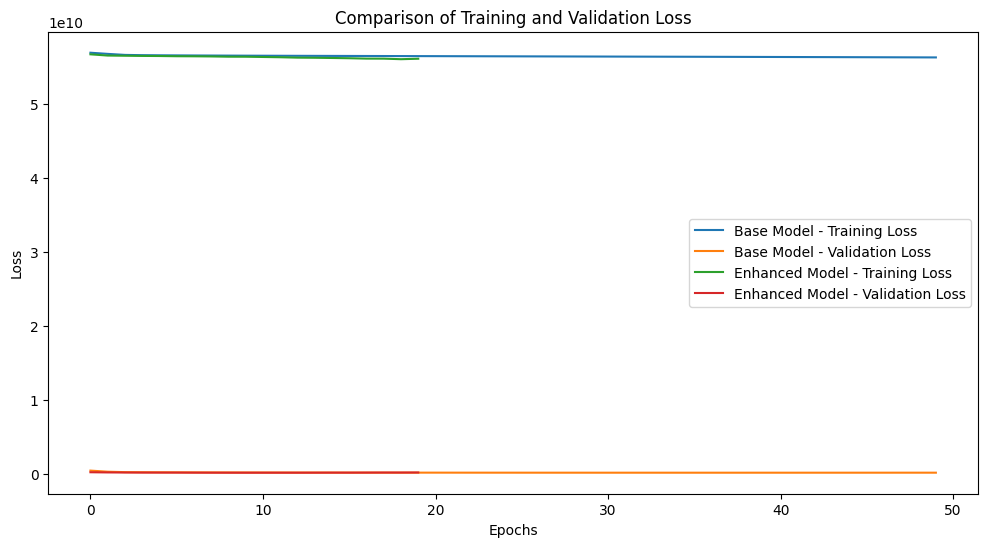

In [33]:
plt.figure(figsize=(12, 6))
plt.plot(base_history.history['loss'], label='Base Model - Training Loss')
plt.plot(base_history.history['val_loss'], label='Base Model - Validation Loss')
plt.plot(enhanced_history.history['loss'], label='Enhanced Model - Training Loss')
plt.plot(enhanced_history.history['val_loss'], label='Enhanced Model - Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Comparison of Training and Validation Loss')
plt.show()

In [34]:
print(f"Base Model MAE: {base_mae}")
print(f"Enhanced Model MAE: {enhanced_mae}")

Base Model MAE: 9715.6025390625
Enhanced Model MAE: 9558.044921875


In [35]:
class MyDense(layers.Layer):

    def __init__(self, units, activation=None, **kwargs):

        super(MyDense, self).__init__(**kwargs)

        self.units = units
        self.activation = activations.get(activation)

    def build(self, input_shape):
        input_dim = input_shape[-1]

        self.kernel = self.add_weight(shape=(input_dim, self.units))

    def call(self, inputs):
        output = tf.matmul(inputs, self.kernel)

        if self.activation is not None:
            output = self.activation(output)

        return output

    def compute_output_shape(self, input_shape):
        output_shape = list(input_shape)
        output_shape[-1] = self.units

        return tuple(output_shape)

    def get_config(self):
        config = super(MyDense, self).get_config()

        current_config = {
            'units': self.units,
            'activation': activations.serialize(self.activation)
        }

        config.update(current_config)

        return config

In [40]:
def build_model():

    model = tf.keras.Sequential([
        MyDense(64, activation='elu', input_shape=[X_train.shape[1]]),
        MyDense(32, activation='elu'),

        layers.Dropout(0.2),

        MyDense(16, activation='elu'),
        MyDense(1)
    ])

    optimizer = tf.keras.optimizers.RMSprop(0.001)

    model.compile(loss='mse',
                  optimizer=optimizer,
                  metrics=['mae', 'mse'])
    return model

In [41]:
sequential_model = build_model()

sequential_model.summary()

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_2548\3431049347.py:5: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(MyDense, self).__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ my_dense (MyDense)              │ (None, 64)             │       108,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ my_dense_1 (MyDense)            │ (None, 32)             │         2,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ my_dense_2 (MyDense)            │ (None, 16)             │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ my_dense_3 (MyDense)            │ (None, 1)              │            16 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 111,312 (434.81 KB)

 Trainable params: 111,312 (434.81 KB)

 Non-trainable params: 0 (0.00 B)

In [42]:
sequential_model.layers

[<MyDense name=my_dense, built=True>,
 <MyDense name=my_dense_1, built=True>,
 <Dropout name=dropout_1, built=True>,
 <MyDense name=my_dense_2, built=True>,
 <MyDense name=my_dense_3, built=True>]

In [48]:
n_epochs = 1000

# Use EarlyStopping to prevent overfitting
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
training_hist = sequential_model.fit(
    X_train, y_train,
    epochs=n_epochs,
    validation_split=0.2,
    verbose=1,  # Show progress bar instead of 'tfdocs.modeling.EpochDots()'
    callbacks=[early_stopping]  # Replace EpochDots with EarlyStopping
)


Epoch 1/1000
385/385 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - loss: 9311600640.0000 - mae: 17664.8340 - mse: 9311600640.0000 - val_loss: 486046528.0000 - val_mae: 14226.6455 - val_mse: 486046528.0000
Epoch 2/1000
385/385 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 109212827648.0000 - mae: 17412.4922 - mse: 109212827648.0000 - val_loss: 300152768.0000 - val_mae: 11464.4082 - val_mse: 300152768.0000
Epoch 3/1000
385/385 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 30053738496.0000 - mae: 13050.8955 - mse: 30053738496.0000 - val_loss: 282670784.0000 - val_mae: 11166.9287 - val_mse: 282670784.0000
Epoch 4/1000
385/385 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 85487755264.0000 - mae: 14653.3408 - mse: 85487755264.0000 - val_loss: 265039376.0000 - val_mae: 10546.7139 - val_mse: 265039376.0000
Epoch 5/1000
385/385 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 12613100544.0000 - mae: 11461.7686 - mse: 12613100544.0000 - val_loss: 249729200.0000 - val_mae: 10239.0439 - val_mse: 249729200.0000
Epoch 6/1000
385/385

121/121 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


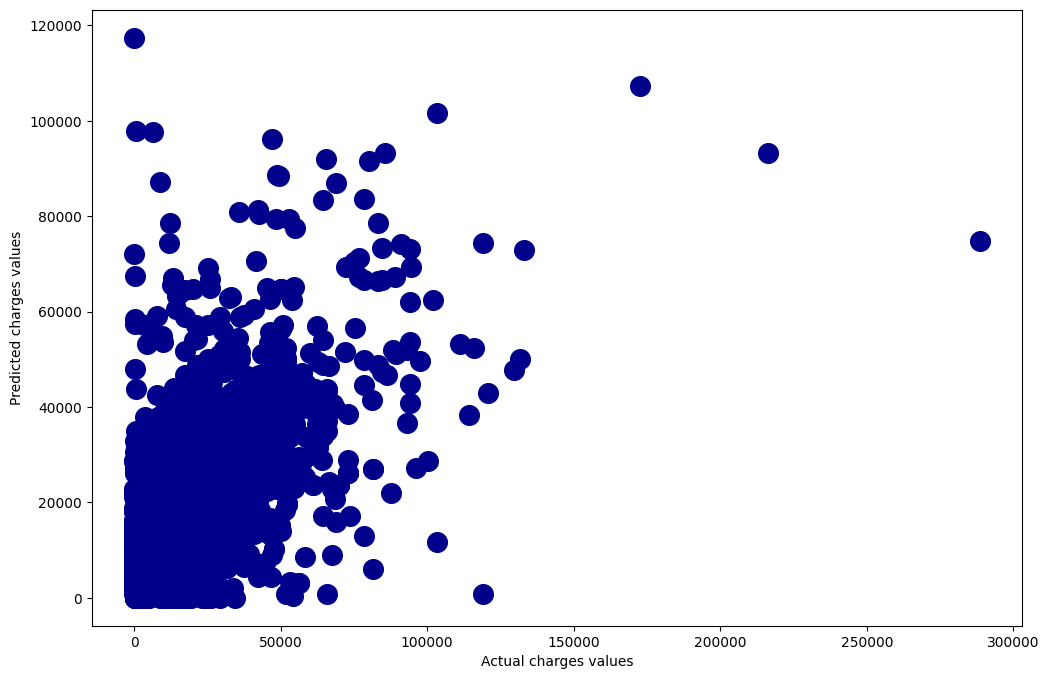

In [50]:
y_pred = sequential_model.predict(X_test).flatten()

plt.figure(figsize=(12, 8))

plt.scatter(y_test, y_pred, s=200, c='darkblue')

plt.xlabel('Actual charges values')
plt.ylabel('Predicted charges values')
plt.show()

In [51]:
r2_score(y_test, y_pred)

0.42426031827926636

In [52]:
class CustomRegressionModel(tf.keras.Model):

    def __init__(self, input_shape, layer_units=[8, 4], \
                 activation='relu'):

        super(CustomRegressionModel, self).__init__()

        assert len(layer_units) > 0

        self.input_layer = MyDense(layer_units[0],
                                   activation=activation,
                                   input_shape=[input_shape])

        self.hidden_layers = []

        for i in range(1, len(layer_units)):
            self.hidden_layers.append(MyDense(layer_units[i],
                                              activation=activation))

        self.output_layer = MyDense(1)

    def call(self, input_tensor):

        x = self.input_layer(input_tensor)

        for layer in self.hidden_layers:
            x = layer(x)

        result = self.output_layer(x)

        return result

In [54]:
custom_model = CustomRegressionModel(X_train.shape[1], [64, 32, 16], 'elu')

custom_model(tf.zeros([5, X_train.shape[1]]))

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_2548\3431049347.py:5: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(MyDense, self).__init__(**kwargs)


<tf.Tensor: shape=(5, 1), dtype=float32, numpy=
array([[0.],
       [0.],
       [0.],
       [0.],
       [0.]], dtype=float32)>

In [55]:
custom_model.layers

[<MyDense name=my_dense_4, built=True>,
 <MyDense name=my_dense_5, built=True>,
 <MyDense name=my_dense_6, built=True>,
 <MyDense name=my_dense_7, built=True>]

In [56]:
custom_model.summary()

Model: "custom_regression_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ my_dense_4 (MyDense)            │ (5, 64)                │       108,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ my_dense_5 (MyDense)            │ (5, 32)                │         2,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ my_dense_6 (MyDense)            │ (5, 16)                │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ my_dense_7 (MyDense)            │ (5, 1)                 │            16 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 111,312 (434.81 KB)

 Trainable params: 111,312 (434.81 KB)

 Non-trainable params: 0 (0.00 B)

In [57]:
optimizer = tf.keras.optimizers.RMSprop(0.001)

custom_model.compile(loss='mse',
                     optimizer=tf.keras.optimizers.RMSprop(0.001),
                     metrics=['mse'])

In [66]:
import tensorflow_docs as tfdocs
import tensorflow_docs.modeling

n_epochs = 1000

X_train_numeric = np.array(X_train, dtype=np.float32)
y_train_numeric = np.array(y_train, dtype=np.float32)

training_hist = custom_model.fit(X_train_numeric,
                                 y_train_numeric,
                                 epochs=n_epochs,
                                 validation_split=0.2,
                                 verbose=False,
                                 callbacks=[tfdocs.modeling.EpochDots()])




Epoch: 0, loss:56342859776.0000,  mse:56342859776.0000,  val_loss:230266960.0000,  val_mse:230266960.0000,  
....................................................................................................
Epoch: 100, loss:56321253376.0000,  mse:56321253376.0000,  val_loss:249680960.0000,  val_mse:249680960.0000,  
....................................................................................................
Epoch: 200, loss:56301211648.0000,  mse:56301211648.0000,  val_loss:309650432.0000,  val_mse:309650432.0000,  
....................................................................................................
Epoch: 300, loss:56287760384.0000,  mse:56287760384.0000,  val_loss:359082048.0000,  val_mse:359082048.0000,  
....................................................................................................
Epoch: 400, loss:56281317376.0000,  mse:56281317376.0000,  val_loss:405230048.0000,  val_mse:405230048.0000,  
..........................................

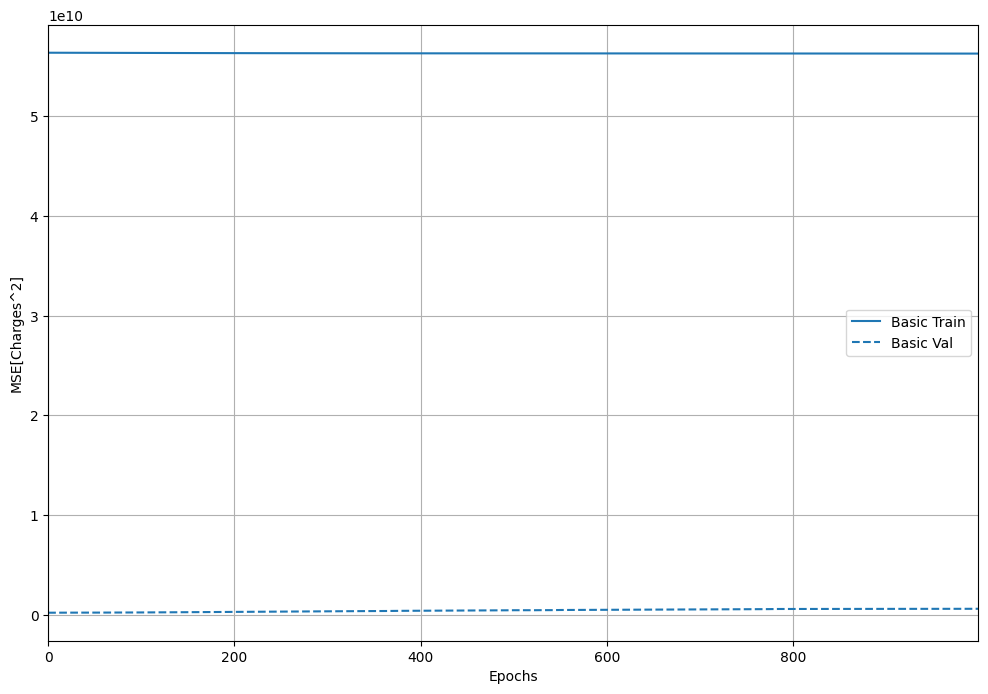

In [68]:
import tensorflow_docs as tfdocs
import tensorflow_docs.plots
plotter = tfdocs.plots.HistoryPlotter(smoothing_std=2)

plt.figure(figsize=(12, 8))

plotter.plot({'Basic': training_hist}, metric = "mse")

plt.ylabel('MSE[Charges^2]')
plt.show()

Levy              float64
Prod. year        float64
Engine volume     float64
Mileage           float64
Cylinders         float64
                   ...   
Color_Red            bool
Color_Silver         bool
Color_Sky blue       bool
Color_White          bool
Color_Yellow         bool
Length: 1699, dtype: object
Levy              0
Prod. year        0
Engine volume     0
Mileage           0
Cylinders         0
                 ..
Color_Red         0
Color_Silver      0
Color_Sky blue    0
Color_White       0
Color_Yellow      0
Length: 1699, dtype: int64
121/121 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


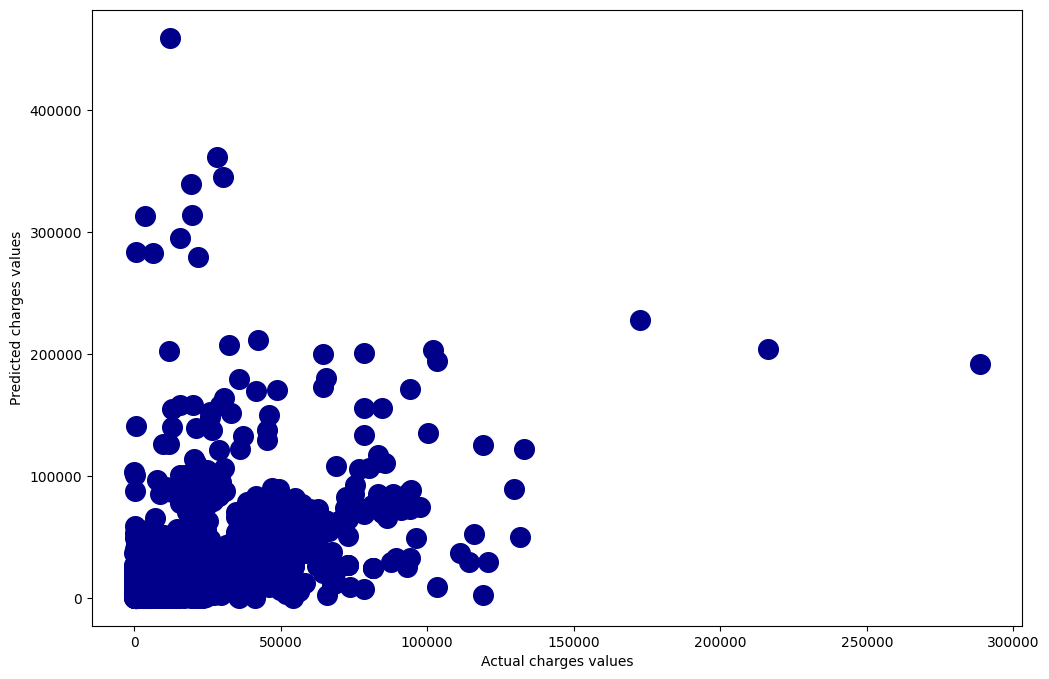

In [72]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Assume X_test is your test features and y_test is your actual labels
# Step 1: Check the data types of X_test
print(X_test.dtypes)

# Step 2: Convert object columns to numeric if necessary
X_test = X_test.apply(pd.to_numeric, errors='coerce')  # Convert to numeric, replace invalid data with NaN

# Step 3: Handle missing values if any
print(X_test.isna().sum())  # Check for missing values
X_test.fillna(0, inplace=True)  # Fill NaNs with 0 (or another strategy)

# Step 4: Ensure the data is in the correct format
X_test = np.array(X_test, dtype=np.float32)

# Step 5: Make predictions
y_pred = custom_model.predict(X_test).flatten()

# Step 6: Plot the results
plt.figure(figsize=(12, 8))
plt.scatter(y_test, y_pred, s=200, c='darkblue')
plt.xlabel('Actual charges values')
plt.ylabel('Predicted charges values')
plt.show()


In [73]:
r2_score(y_test, y_pred)

-0.7807133197784424

In [77]:
custom_model.save_weights('my_models/custom_model.weights.h5')

FileNotFoundError: [Errno 2] Unable to synchronously create file (unable to open file: name = 'my_models/custom_model.weights.h5', errno = 2, error message = 'No such file or directory', flags = 13, o_flags = 302)

In [78]:
new_model = CustomRegressionModel(X_train.shape[1], [64, 32, 16], 'elu')

new_model(tf.zeros([5, X_train.shape[1]]))

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_2548\3431049347.py:5: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(MyDense, self).__init__(**kwargs)


<tf.Tensor: shape=(5, 1), dtype=float32, numpy=
array([[0.],
       [0.],
       [0.],
       [0.],
       [0.]], dtype=float32)>

In [79]:
optimizer = tf.keras.optimizers.RMSprop(0.001)

new_model.compile(loss='mse',
                  optimizer=tf.keras.optimizers.RMSprop(0.001),
                  metrics=['mse'])

In [80]:
new_model.load_weights('my_models/custom_model.h5')

FileNotFoundError: [Errno 2] Unable to synchronously open file (unable to open file: name = 'my_models/custom_model.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [85]:
y_pred_new = new_model.predict(X_test.values)  # Use .values for older pandas versions
r2_score(y_test, y_pred_new)


AttributeError: 'numpy.ndarray' object has no attribute 'values'